In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
from memflow.transfer_flow.transfer_flow import TransferFlow
from memflow.transfer_flow.transfer_flow_paper import TransferFlow_Paper
from utils import alter_variables
from utils import alter_variables_tensor

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak


from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

# Start with checking the Transformer

# For testing: The model must be always on 'eval' mode
# For testing: Never save the gradients (`.detech().cpu()`)

In [3]:
batchSize = 128

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_v2/Transfer_Flow_transfer flow_test_DiagNormal_NoTransf4_NoBins30_DNN:2_128'
path_to_conf = model_dir + '/config_transfer flow_test.yaml'
path_to_model = model_dir + '/model_transfer flow_test.pt'

with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)
        
path_data = config.input_dataset_test
#path_data = config.input_dataset_validation
print(path_data)

/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2.parquet


In [4]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 13532528640
used     : 2573598720


In [5]:
transfer_flow = TransferFlow(no_recoVars=config.input_shape.no_recoVars,
                no_partonVars=config.input_shape.no_partonVars,

                transformer_input_features=config.transformerConditioning.input_features,
                transformer_nhead=config.transformerConditioning.nhead,
                transformer_num_encoder_layers=config.transformerConditioning.no_encoder_layers,
                transformer_num_decoder_layers=config.transformerConditioning.no_decoder_layers,
                transformer_dim_feedforward=config.transformerConditioning.dim_feedforward,
                transformer_activation=nn.GELU(),
                 
                flow_nfeatures=config.transferFlow.nfeatures,
                flow_ntransforms=config.transferFlow.ntransforms,
                flow_hiddenMLP_NoLayers=config.transferFlow.hiddenMLP_NoLayers,
                flow_hiddenMLP_LayerDim=config.transferFlow.hiddenMLP_LayerDim,
                flow_bins=config.transferFlow.bins,
                flow_autoregressive=config.transferFlow.autoregressive,
                flow_base=config.transferFlow.base,
                flow_base_first_arg=config.transferFlow.base_first_arg,
                flow_base_second_arg=config.transferFlow.base_second_arg,
                flow_bound=config.transferFlow.bound,
                randPerm=config.transferFlow.randPerm,
                no_max_objects=config.transferFlow.no_max_objects,
                 
                device=device,
                eps=1e-4)

state_dict = torch.load(path_to_model, map_location=device)
transfer_flow.load_state_dict(state_dict['model_state_dict'])

if device == torch.device('cuda'):
    transfer_flow = transfer_flow.cuda()

In [6]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 13025017856
used     : 3081109504


In [7]:
test_data = DatasetCombined(path_data, dev=device, datasets=["partons_lab", "reco_lab"], dtype=torch.float64,
                    reco_list_lab=['recoParticles',
                                   'scaledLogRecoParticles', 'mask_lepton', 
                                        'mask_jets','mask_met',
                                        'mask_boost', 'data_boost'],
                    parton_list_lab=['data_higgs_t_tbar_ISR',
                                     "logScaled_data_higgs_t_tbar_ISR"])


>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cuda) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load recoParticles
Load scaledLogRecoParticles
Reco: Move tensors to device (cuda) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [8]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 4592369664
used     : 11513757696


In [9]:
testLoader = DataLoader(
        test_data,
        batch_size=batchSize,
        #shuffle=True,
        shuffle=False,
    )

In [10]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 4416208896
used     : 11689918464


In [11]:
No_ev = 100
perm = torch.randperm(len(test_data))
list_ev = perm[:No_ev]
#print(list_ev.tolist())
oldVersion = False

log_mean_parton = test_data.partons_lab.mean_log_data_higgs_t_tbar_ISR
log_std_parton = test_data.partons_lab.std_log_data_higgs_t_tbar_ISR
log_mean_reco = test_data.reco_lab.meanRecoParticles
log_std_reco = test_data.reco_lab.stdRecoParticles
    
if device == torch.device('cuda'):
    log_mean_parton = log_mean_parton.cuda()
    log_std_parton = log_std_parton.cuda()
    log_mean_reco = log_mean_reco.cuda()
    log_std_reco = log_std_reco.cuda()

if oldVersion:

    scaledLogReco = test_data.reco_lab.scaledLogRecoParticles[list_ev,:,:7]
    scaledLogParton = test_data.partons_lab.logScaled_data_higgs_t_tbar_ISR[list_ev]
    maskJets = test_data.reco_lab.mask_jets[list_ev]
    maskLepton = test_data.reco_lab.mask_lepton[list_ev]
    maskMET = test_data.reco_lab.mask_met[list_ev]

    boostReco = test_data.reco_lab.data_boost[list_ev]
    maskBoost = test_data.reco_lab.mask_boost[list_ev]

    maskedReco = torch.cat((maskJets, maskLepton, maskMET), dim=1)

    recoParticles = test_data.reco_lab.recoParticles[list_ev]
    data_partons = test_data.partons_lab.data_higgs_t_tbar_ISR[list_ev]

    if device == torch.device('cuda'):
        scaledLogReco = scaledLogReco.cuda()
        scaledLogParton = scaledLogParton.cuda()
        boostReco = boostReco.cuda()
        maskBoost = maskBoost.cuda()
        maskedReco = maskedReco.cuda()
        recoParticles = recoParticles.cuda()
        data_partons = data_partons.cuda()

# I. modify jets

## let's scan pt: (-10%, ..., +10%): 20 values
## let's scan eta: (-0.5, -0.45, ..., 0.45, 0.5): 20 values

## let's modify the values of random no of jets: from 1 to 7
## let's modify the values of random jets: from 1 to 7


In [12]:
No_batches = 100
print(len(testLoader))

14001


In [13]:
def plot_per_change(diff_logprob, diff_change, modify_particles, title_var='% pt'):
    for idx, change in enumerate(diff_change):
        x = plt.hist(diff_logprob[idx, :].flatten().numpy(), bins=100)
        
        title = f'change: {change} {title_var}     modified_particles:{modify_particles}'
        plt.title(title)
        plt.show()

In [14]:
no_jets = torch.randint(1, 7, (1,))
print(no_jets)

perm = torch.randperm(7)
modify_jets = perm[:no_jets]
modify_jets, indices = torch.sort(modify_jets)
print(modify_jets.tolist())

tensor([6])
[1, 2, 3, 4, 5, 6]


In [15]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 4674158592
used     : 11431968768


In [16]:
target_events_logprob = torch.zeros((No_batches, batchSize), device=torch.device('cpu'))

iterator = iter(testLoader)
for idx in range(No_batches):
    transfer_flow.eval()
    data_batch = next(iterator)
    
    (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
    recoParticles, scaledLogRecoParticles, mask_lepton, 
    mask_jets, mask_met, mask_boost, boostReco) = data_batch
    
    maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)
    
    scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
    avg_flowPr, target_batch_flow_pr, flow_pr = transfer_flow(scaledLogRecoParticles,
                                                                logScaled_data_higgs_t_tbar_ISR,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)
    
    target_events_logprob[idx] = target_batch_flow_pr.detach().cpu()

/home/user/micromamba/lib/python3.9/site-packages/zuko/transforms.py:425: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.searchsorted(seq, value[..., None]).squeeze(dim=-1)


## 1st: modify pt of jets (percent)

In [17]:
percentage_change = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]
diff_logprob_jets_pt = torch.zeros((len(percentage_change), No_batches, batchSize))

transfer_flow.eval()
for index, percent in enumerate(percentage_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
        difference_pt = percent/100*recoParticles[:,modify_jets,0]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_pt,
                                                object_no=modify_jets,
                                                variable_altered=[0],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)

        diff_logprob_jets_pt[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

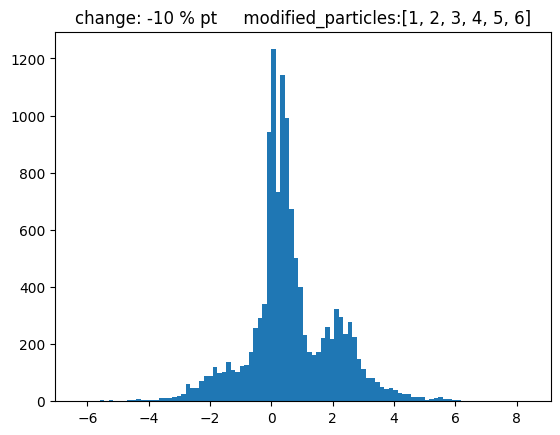

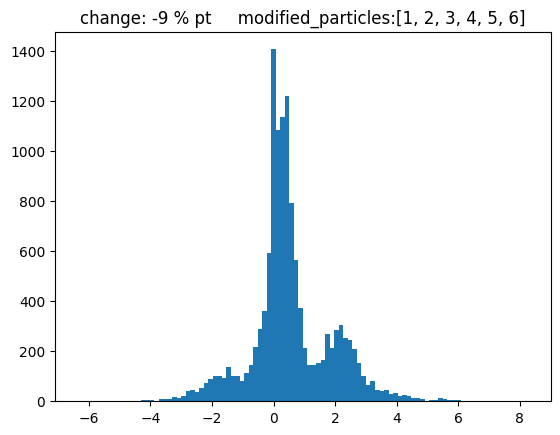

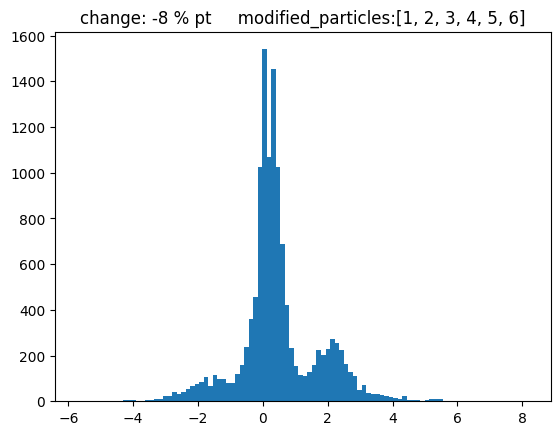

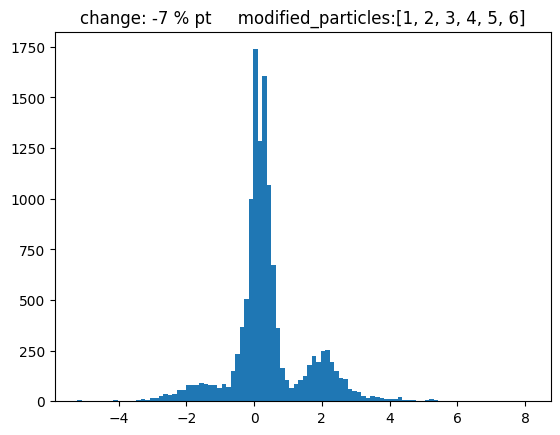

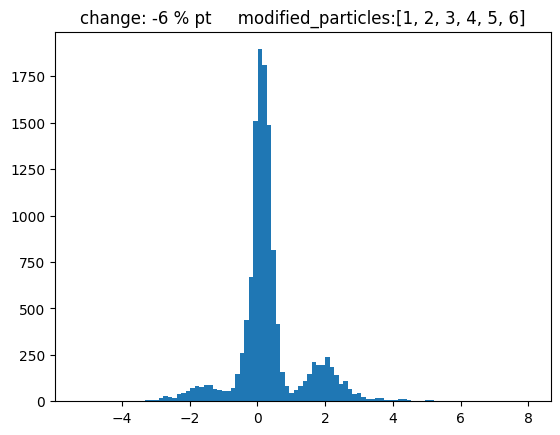

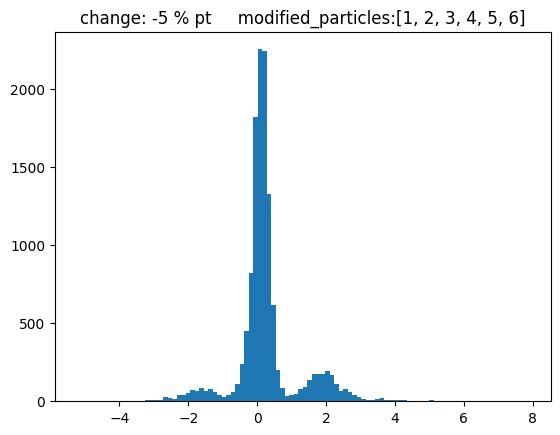

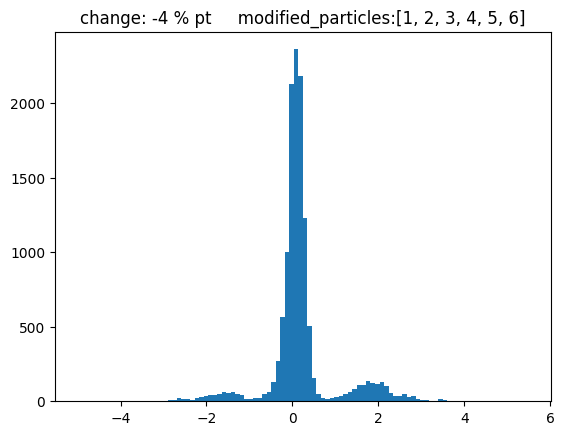

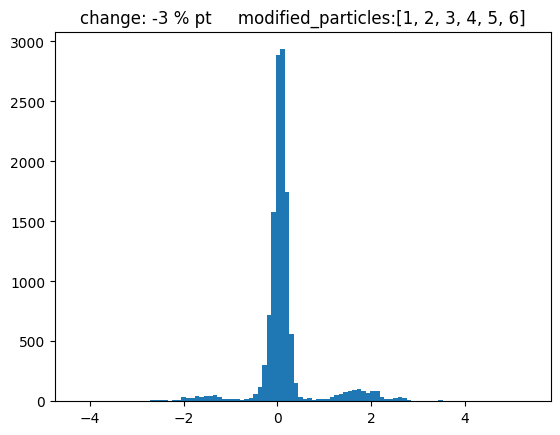

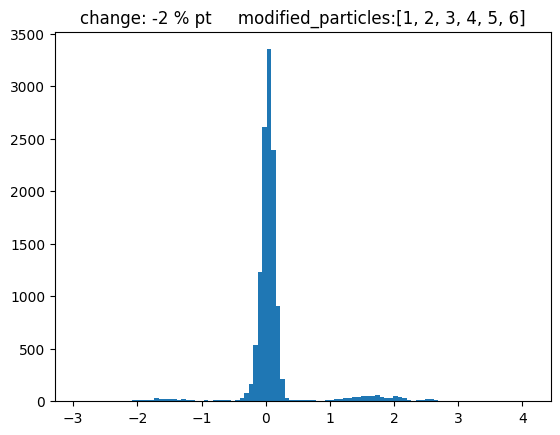

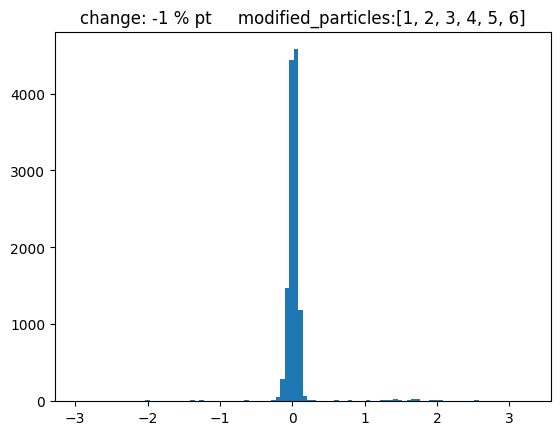

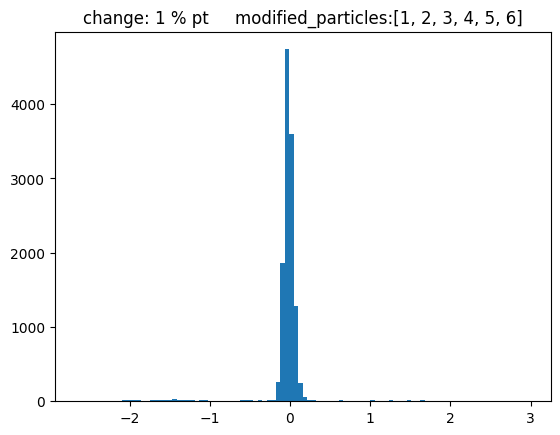

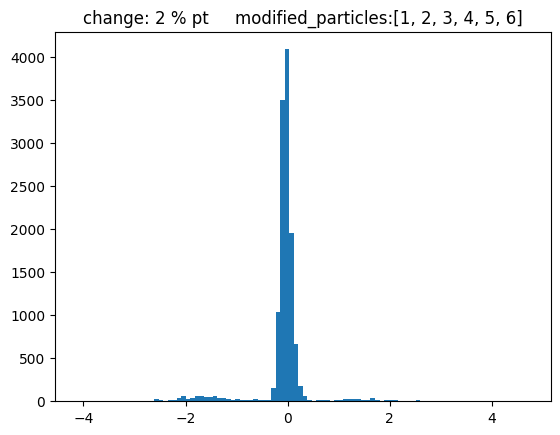

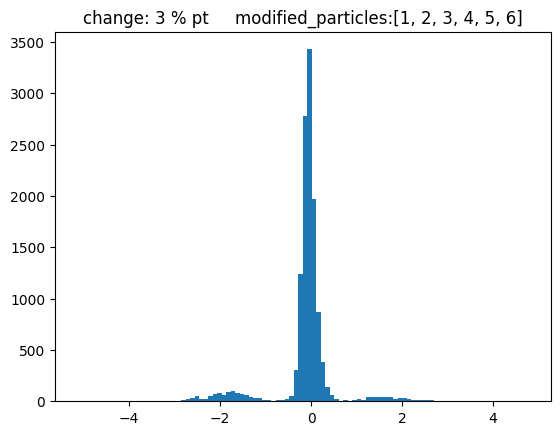

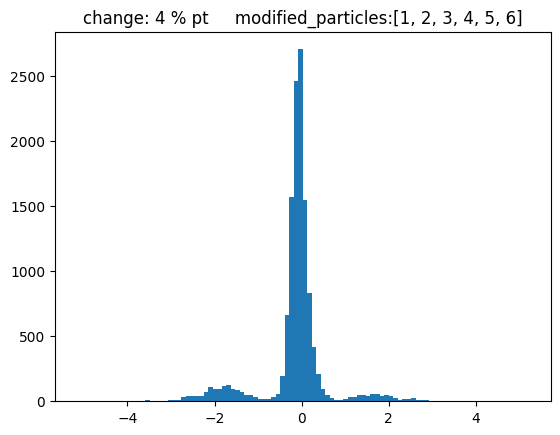

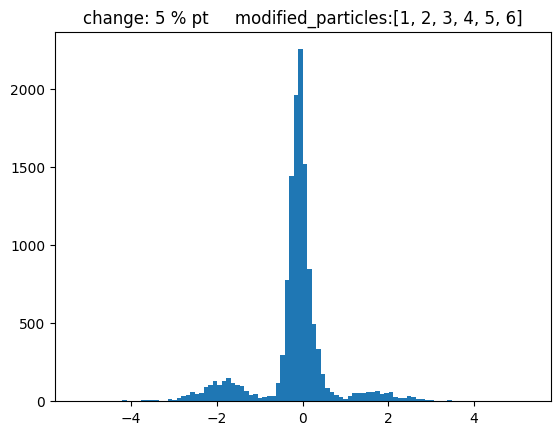

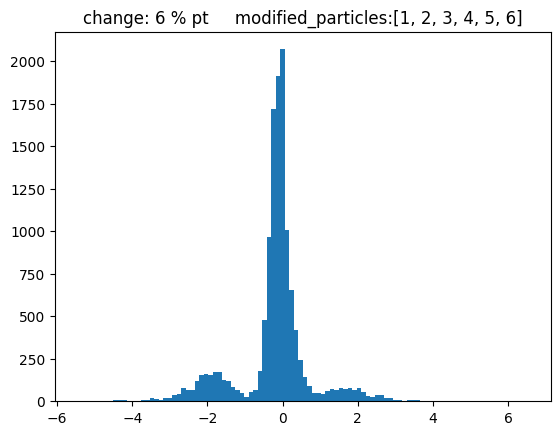

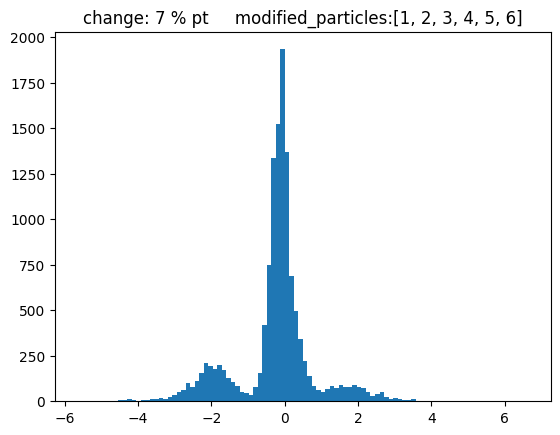

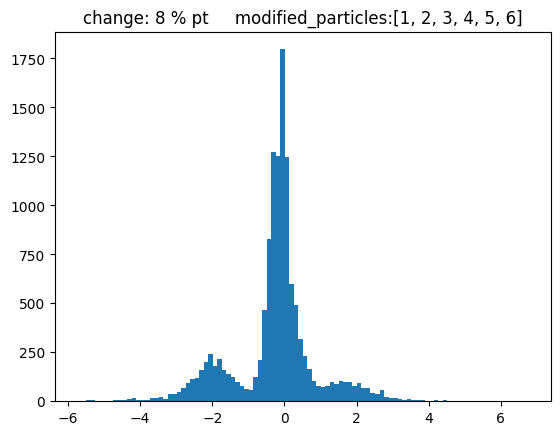

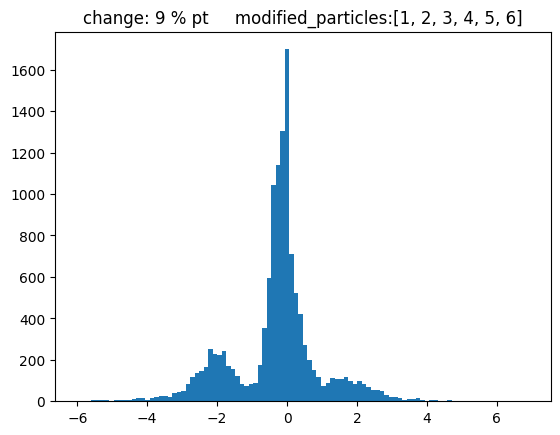

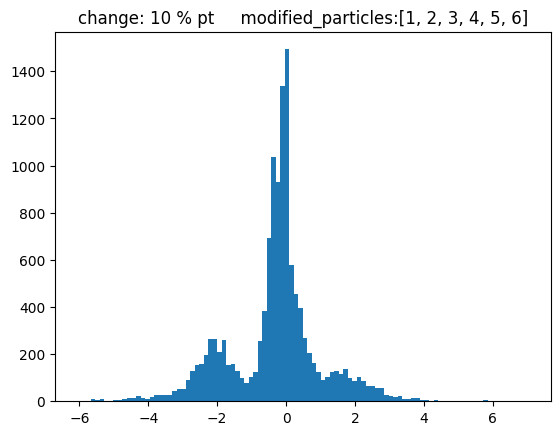

In [18]:
plot_per_change(diff_logprob_jets_pt, percentage_change, modify_jets.tolist(), title_var='% pt')

# 2nd: modify eta of jets

In [ ]:
eta_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 5]
diff_logprob_jets_eta = torch.zeros((len(eta_change), No_batches, batchSize))

for index, difference_eta in enumerate(eta_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_eta,
                                                object_no=modify_jets,
                                                variable_altered=[1],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)

        diff_logprob_jets_eta[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [ ]:
plot_per_change(diff_logprob_jets_eta, eta_change, modify_jets.tolist(), title_var=' eta')

In [ ]:
# 3rd: modify phi of jets

In [ ]:
phi_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 5]
diff_logprob_jets_phi = torch.zeros((len(phi_change), No_batches, batchSize))

for index, difference_phi in enumerate(phi_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_phi,
                                                object_no=modify_jets,
                                                variable_altered=[2],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)

        diff_logprob_jets_phi[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [ ]:
plot_per_change(diff_logprob_jets_phi, phi_change, modify_jets.tolist(), title_var=' phi')

In [ ]:
# II. Change partons

In [ ]:
no_partons = torch.randint(1, 4, (1,))
print(no_partons)

perm = torch.randperm(4)
modify_partons = perm[:no_partons]
modify_partons, indices = torch.sort(modify_partons)
print(modify_partons.tolist())

mask_partons = torch.ones((batchSize, 4))

In [ ]:
# 1st. modify pt of partons

In [ ]:
percentage_change = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]
diff_logprob_partons_pt = torch.zeros((len(percentage_change), No_batches, batchSize))

transfer_flow.eval()
for index, percent in enumerate(percentage_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
        difference_pt = percent/100*data_higgs_t_tbar_ISR[:,modify_partons,0]
        
        wrong_logScaled_partons = alter_variables_tensor(difference=difference_pt,
                                                object_no=modify_partons,
                                                variable_altered=[0],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)

        diff_logprob_partons_pt[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [ ]:
plot_per_change(diff_logprob_partons_pt, percentage_change, modify_partons.tolist(), title_var=' % pt')

In [ ]:
# 2nd: change eta of partons

In [ ]:
eta_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 5]
diff_logprob_partons_eta = torch.zeros((len(eta_change), No_batches, batchSize))

transfer_flow.eval()
for index, diff_eta in enumerate(eta_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
            
        wrong_logScaled_partons = alter_variables_tensor(difference=diff_eta,
                                                object_no=modify_partons,
                                                variable_altered=[1],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)

        diff_logprob_partons_eta[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [ ]:
plot_per_change(diff_logprob_partons_eta, eta_change, modify_partons.tolist(), title_var=' eta')

In [ ]:
# 3rd: change phi of partons

In [ ]:
phi_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 5]
diff_logprob_partons_phi = torch.zeros((len(phi_change), No_batches, batchSize))

transfer_flow.eval()
for index, diff_phi in enumerate(diff_logprob_partons_phi):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
            
        wrong_logScaled_partons = alter_variables_tensor(difference=diff_phi,
                                                object_no=modify_partons,
                                                variable_altered=[2],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        avg_flowPr, wrong_batch_flow_pr, flow_pr = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)

        diff_logprob_partons_phi[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [ ]:
plot_per_change(diff_logprob_partons_phi, phi_change, modify_partons.tolist(), title_var=' phi')